# Deep Learning for Computer Vision:  HW 1


## Computer Science: COMS W 4995 004


### Due: September 29, 2020

#### Problem 1

Let's start with a two class classification problem. You are asked to

1. Create your own dataset using real data. This data can be found by you online or gathered and measured by you. You are not to use datasets that others have put together, instead you are looking for raw data for a two class classification problem. The data does not have to come from images, but it is ok if it does. The data should contain 100 or more samples (more is better) from each class and the features should be at least 2 dimensional. It is ok to use Python libs, e.g. OpenCV, to extract features from your raw data. And it is ok if the labels for the classes are given by the data, or you can annotate this data yourself. 

2. Divide this data up into a training set (80%) and a validation set (20%). Experiment with plotting this data in some of the raw feature dimensions much like we did in class. Hand-draw possible classifiers in these plots. 

3. Compute the prior for both classes from the data you gathered. Or if you do not believe you can determine this, assume both classes are equally likely. If you only have a couple of features, you can try to fit to a multivariate Gaussian class conditional density functions--this simply means you need to find the sample mean and sample covariance matrix for both classes from the samples. Alternatively, you can use a naive Bayes algorithm that assumes each feature is independent. But again assume a Gaussian distribution for each and find the joint probability as the product of the per feature probabilities. Plot the decision boundary for a minimum error-rate classifier assuming your fits are correct. Are these good fits to your data? How does this decision boundary differ from the one you drew by hand?

To make things more consistent, let's all use the same notation.  Let the class conditional density functions (or likelihoods) be given by $\rho({\bf x}|y_i)$ where ${\bf x}$ is your feature and $y_i$ specifies the class. Let's also assume that the priors $P(y_i)$ are the same for both classes. Hint: you can find the decision boundary by densely generating sample points ${\bf x}_j \in X$ according to your ccd's, classifying them, and then plotting and coloring them according to their predicted label.

Remember all you need to do is to use Bayes theorem to get the expression for $P(y_i|{\bf x})$, then for each sample ${\bf x}_j \in X$ choose the $i$ with the highest aposteriori probability. Do not use any statisical packages to do this other than numpy to fit to your Gaussian distribution(s).

# Problem 1.1 and 1.2

## Data Description

I use image data, taken from Google. The classes are "Central Park" and "Time Square". Each class has 120 data in total, with 96 of them being the train set and the other 24 of them being the test set.

In [1]:
!pip install matplotlib numpy opencv-python scipy 

You should consider upgrading via the 'pip install --upgrade pip' command.


## Check that we have access to the data and the number of data is correct

In [2]:
!ls "data/train/centralpark" | wc -l
!ls "data/train/timesquare" | wc -l
!ls "data/test/centralpark" | wc -l
!ls "data/test/timesquare" | wc -l

      96
      96
      24
      24


## Imports and Dir Constants

In [3]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy.stats import multivariate_normal
from datetime import datetime

base_path        = 'data'
train_path       = base_path + '/train'
test_path        = base_path + '/test'

## Determine Fixed Size

I find that for both train and test data, there is no image with lower resolution than 200x200, so I pick that as my fixed size

In [4]:
def fetch_dim(image, label):
    height, width, channels = image.shape
    return label, height, width

def find_min_size(is_train, threshold):
  # Pick the corresponding path
  if is_train:
    print('Find in train data ...')
    data_path = train_path
  else:
    print('Find in test data ...')
    data_path = test_path

  # Get the labels, sorted, in this case it's just ['cats', 'dogs']
  classes = sorted(os.listdir(data_path))

  # Array to store image size
  image_sizes = []

  # Loop over each dir, each corresponds to a label
  for label in classes:
      # Get dir full path
      dir = os.path.join(data_path, label)
      
      if '.DS_Store' not in dir:
          # Loop over the images in the dir
          for image_file in os.listdir(dir):
              image_path = os.path.join(dir, image_file)

              # Calculate size
              if 'HEIC' not in image_path:
                image = cv2.imread(image_path)
                image_sizes.append(fetch_dim(image, label))

  # Return all image sizes that are less than the size threshold
  return [elem for elem in image_sizes if elem[0] == classes[0] and elem[1] < threshold and elem[2] < threshold], [elem for elem in image_sizes if elem[0] == classes[1] and elem[1] < threshold and elem[2] < threshold]

train_min_size = find_min_size(True, 200)
print(len(train_min_size[0]), len(train_min_size[1]))

test_min_size = find_min_size(False, 200)
print(len(test_min_size[0]), len(test_min_size[1]))

# Set fixed_size constant
fixed_size = tuple([200, 200])

Find in train data ...
0 0
Find in test data ...
0 0


## Feature Extractor Function

I use Color Histogram from OpenCV as my feature, with the following detail:
1. Using three channels (RGB), denoted by [0 1 2]
2. The color range is default, 0 to 256
3. There are 8 bins (I handpick this, no particular reason).

The above scenario results in a feature vector of size 512.

In [5]:
bins = 8

# Color Histogram Feature
# a. Convert the image to HSV color-space
# b. Compute the color histogram
# c. Normalize the histogram
def compute_histogram(image, mask=None):
    hist = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2HSV)], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

## Precompute the Features for Train and Test Data

In [6]:
image_sizes = []

def precompute_features(is_train, is_timed):
  if is_timed:
    start = datetime.now()

  # Pick the corresponding path
  if is_train:
    print('Precomputing train data features...')
    data_path = train_path
  else:
    print('Precomputing test data features...')
    data_path = test_path

  # Placeholder for returned features and labels
  features = []
  labels = []

  # Get the labels, sorted, in this case it's just ['cats', 'dogs']
  classes = sorted(os.listdir(data_path))

  # Loop over each dir, each corresponds to a label
  for label in classes:
      # Get dir full path
      dir = os.path.join(data_path, label)

      if '.DS_Store' not in dir:
          # Loop over the images in the dir
          for image_file in os.listdir(dir):
              image_path = os.path.join(dir, image_file)

              # Resize image, refer to the previous constant
              if 'HEIC' not in image_path:
                image = cv2.imread(image_path)
                image_sizes.append(fetch_dim(image, label))
                image = cv2.resize(image, fixed_size)

              # Extract three different features
              hist = compute_histogram(image) 
              # print(hist.shape) #(512, )

              # Append to placeholder
              features.append(hist)
              labels.append(label)

          print("Time elapsed: {}".format(datetime.now() - start)) 
          print("Processed dir: {}".format(label))
    
  return np.array(features), labels

train_features, train_labels = precompute_features(True, True)
test_features, test_labels = precompute_features(False, True)

Precomputing train data features...
Time elapsed: 0:00:00.116182
Processed dir: centralpark
Time elapsed: 0:00:00.248634
Processed dir: timesquare
Precomputing test data features...
Time elapsed: 0:00:00.029898
Processed dir: centralpark
Time elapsed: 0:00:00.054528
Processed dir: timesquare


## Scatter Plot and Hand-Drawn Classifier

The total number of features are 512, i.e. a vector of size 512, from the Color Histogram.

Hence, for the scatter plot, I'm going to separate the vector into two vectors of size 256 each and then take the average of each of them, resulting in 2D feature.

First, some sanity check on our features.

In [7]:
print(train_features.shape)
print(test_features.shape)

(192, 512)
(48, 512)


Convert the 512 sized vector into a vector of size 2 using the method I've mentioned before.

In [8]:
feature_dim = len(train_features[0])

# Take the features from the train set
train_hist_1 = train_features[:, 0:(feature_dim//2)]
train_hist_2 = train_features[:, (feature_dim//2):feature_dim]

# Take the average of those features
train_avg_hist_1 = train_hist_1.mean(axis=1) # (192, )
train_avg_hist_2 = train_hist_2.mean(axis=1) # (192, )

# Find indexes where the label corres
c_train_idxs = [idx for idx, label in enumerate(train_labels) if label == 'centralpark']
t_train_idxs = [idx for idx, label in enumerate(train_labels) if label == 'timesquare']

# Use the idx to slice the corresponding feature
c_train_avg_hist_1 = train_avg_hist_1[c_train_idxs]
c_train_avg_hist_2 = train_avg_hist_2[c_train_idxs]

t_train_avg_hist_1 = train_avg_hist_1[t_train_idxs]
t_train_avg_hist_2 = train_avg_hist_2[t_train_idxs]

Plot the points as a Scatter Plot for Training Set

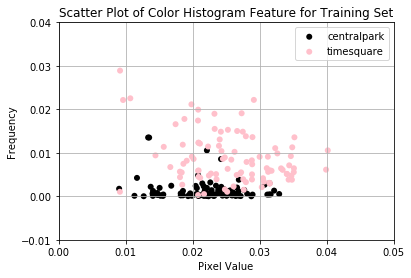

In [9]:
fig, ax = plt.subplots()

ax.scatter(c_train_avg_hist_1, c_train_avg_hist_2, c='black', label='centralpark', edgecolors='none')
ax.scatter(t_train_avg_hist_1, t_train_avg_hist_2, c='pink', label='timesquare', edgecolors='none')

ax.set_xlabel('Pixel Value')     
ax.set_ylabel('Frequency')

ax.set_xlim(0, 0.05)
ax.set_ylim(-0.01, 0.04)

ax.set_title('Scatter Plot of Color Histogram Feature for Training Set')
ax.legend()
ax.grid(True)

plt.show()

We can see that some reasonable hand-drawn classifier would be a horizontal line drawn somewhere around $0.002$ to $0.004$. 

Let's take $0.003$ and see if that separates well the data. 

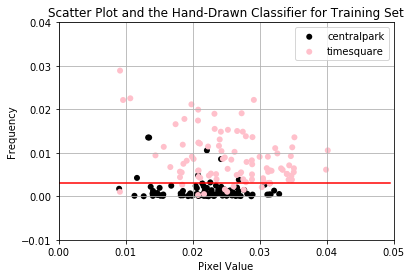

In [10]:
fig, ax = plt.subplots()

ax.scatter(c_train_avg_hist_1, c_train_avg_hist_2, c='black', label='centralpark', edgecolors='none')
ax.scatter(t_train_avg_hist_1, t_train_avg_hist_2, c='pink', label='timesquare', edgecolors='none')

x_plots = np.arange(0, 0.05, 0.0005)
y_plots = np.array([0.003]*len(x_plots)) 
ax.plot(x_plots, y_plots, color='red')

ax.set_xlabel('Pixel Value')     
ax.set_ylabel('Frequency')     

ax.set_xlim(0, 0.05)
ax.set_ylim(-0.01, 0.04)

ax.set_title('Scatter Plot and the Hand-Drawn Classifier for Training Set')
ax.legend()
ax.grid(True)

plt.show()

From the plot above, we can see that $y=0.003$ seems to be good enough even though we can't achieve zero error rate (which is very hard anyway if we only  use a simple decision boundary like a straight line or even a curve).

Let's now make one for the test set.

In [11]:
feature_dim = len(test_features[0])

# Take the features from both train and test
test_hist_1 = test_features[:, 0:(feature_dim//2)]
test_hist_2 = test_features[:, (feature_dim//2):feature_dim]

# Take the average of those 13 features
test_avg_hist_1 = test_hist_1.mean(axis=1) # (24, )
test_avg_hist_2 = test_hist_2.mean(axis=1) # (24, )

# Find indexes where the label is cats/dogs
c_test_idxs = [idx for idx, label in enumerate(test_labels) if label == 'centralpark']
t_test_idxs = [idx for idx, label in enumerate(test_labels) if label == 'timesquare']

# Use the idx to slice the corresponding feature
c_test_avg_hist_1 = test_avg_hist_1[c_test_idxs]
c_test_avg_hist_2 = test_avg_hist_2[c_test_idxs]

t_test_avg_hist_1 = test_avg_hist_1[t_test_idxs]
t_test_avg_hist_2 = test_avg_hist_2[t_test_idxs]

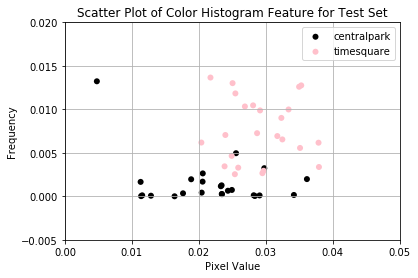

In [12]:
fig, ax = plt.subplots()

ax.scatter(c_test_avg_hist_1, c_test_avg_hist_2, c='black', label='centralpark', edgecolors='none')
ax.scatter(t_test_avg_hist_1, t_test_avg_hist_2, c='pink', label='timesquare', edgecolors='none')

ax.set_xlabel('Pixel Value')     
ax.set_ylabel('Frequency')     

ax.set_xlim(0, 0.05)
ax.set_ylim(-0.005, 0.02)

ax.set_title('Scatter Plot of Color Histogram Feature for Test Set')
ax.legend()
ax.grid(True)

plt.show()

We see similar pattern to that of the train set. However, in this case we might want to tweak the horizontal line into something like $y=0.002$. 


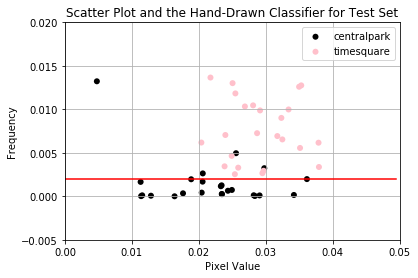

In [13]:
fig, ax = plt.subplots()

ax.scatter(c_test_avg_hist_1, c_test_avg_hist_2, c='black', label='centralpark', edgecolors='none')
ax.scatter(t_test_avg_hist_1, t_test_avg_hist_2, c='pink', label='timesquare', edgecolors='none')

x_plots = np.arange(0, 0.05, 0.0005)
y_plots = np.array([0.002]*len(x_plots)) 
ax.plot(x_plots, y_plots, color='red')

ax.set_xlabel('Pixel Value')     
ax.set_ylabel('Frequency') 

ax.set_xlim(0, 0.05)
ax.set_ylim(-0.005, 0.02)

ax.set_title('Scatter Plot and the Hand-Drawn Classifier for Test Set')
ax.legend()
ax.grid(True)

plt.show()

Again, we couldn't achieve zero error rate in this case since some points are mixed up with the other groups, i.e. some black points are in the pink area.

# Problem 1.3

## The Prior for Both Classes

Since I'm taking the images from Google and I don't know the true distribution of both classes, then I'm assuming both are equally likely. Thus, suppose "Central Park" is Class 0 and "Time Square" is Class 1, then:

$$P(y_0) = P(y_1) = 0.5$$

Furthermore, we can't omit this prior probability when we do the classification, i.e. computing the posterior probability, because the order won't change anyway. In other words, whether or not we use the prior, the class with the higher probability will stay the same.

##Multivariate Gaussian Class Conditional Density Functions





Since I'm only using two features, I will try to fit a Multivariate Gaussian Class Conditional Density function. First, we compute the sample mean and covariance matrix for both classes as below.

In [14]:
c_train_mean = np.array([np.mean(c_train_avg_hist_1), np.mean(c_train_avg_hist_2)])
# To compute the covariance matrix is a little tricky, we need to first
# stack vertically observation from both variables, because np.cov
# accepts input of size (n_var, n_obs)
c_train_cov = np.cov(np.vstack([c_train_avg_hist_1, c_train_avg_hist_2]))

t_train_mean = np.array([np.mean(t_train_avg_hist_1), np.mean(t_train_avg_hist_2)])
t_train_cov = np.cov(np.vstack([t_train_avg_hist_1, t_train_avg_hist_2]))

print(c_train_mean)
print(c_train_cov)

print(t_train_mean)
print(t_train_cov)

[0.021942   0.00142054]
[[ 2.73400980e-05 -1.94698046e-06]
 [-1.94698046e-06  5.67771370e-06]]
[0.02571169 0.00871228]
[[ 4.41106247e-05 -1.23979111e-05]
 [-1.23979111e-05  3.31023119e-05]]


We will then use the Gaussian function to plot our test data.
But first, let us revisit our previous scatter plot for the test data.

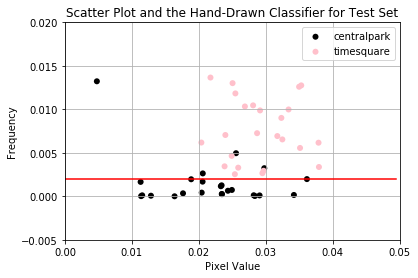

In [15]:
fig, ax = plt.subplots()

ax.scatter(c_test_avg_hist_1, c_test_avg_hist_2, c='black', label='centralpark', edgecolors='none')
ax.scatter(t_test_avg_hist_1, t_test_avg_hist_2, c='pink', label='timesquare', edgecolors='none')

x_plots = np.arange(0, 0.05, 0.0005)
y_plots = np.array([0.002]*len(x_plots)) 
ax.plot(x_plots, y_plots, color='red')

ax.set_xlabel('Pixel Value')     
ax.set_ylabel('Frequency')     

ax.set_xlim(0, 0.05)
ax.set_ylim(-0.005, 0.02)

ax.set_title('Scatter Plot and the Hand-Drawn Classifier for Test Set')
ax.legend()
ax.grid(True)

plt.show()

Now, let's plot using our Gaussian and let's see if it resembles the true distribution as above. First, we compute the probability of each point being in each class according to the Gaussian. I will use SciPy here. Then, we pick the class with the bigger probability as our classification decision.

In [16]:
zipped_test_features = np.array(list(zip(test_avg_hist_1, test_avg_hist_2)))

c_probs = multivariate_normal.pdf(zipped_test_features, mean=c_train_mean, cov=c_train_cov)
t_probs = multivariate_normal.pdf(zipped_test_features, mean=t_train_mean, cov=t_train_cov)

# True means it's Central Park, Time Square otherwise
classification_result = c_probs > t_probs 
# print(classification_result[0:10])

# Get the indexes for each class
c_test_idxs = [idx for idx, label in enumerate(classification_result) if label]
t_test_idxs = [idx for idx, label in enumerate(classification_result) if not label]

# print(c_test_idxs[0:10])
# print(t_test_idxs[0:10])

# Use the idx to slice the corresponding data
c_test_feature = zipped_test_features[c_test_idxs]
t_test_feature = zipped_test_features[t_test_idxs]

# print(c_test_feature[0:10])
# print(t_test_feature[0:10])

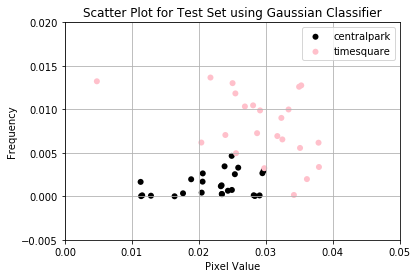

In [17]:
fig, ax = plt.subplots()

ax.scatter(c_test_feature[:, 0], c_test_feature[:, 1], c='black', label='centralpark', edgecolors='none')
ax.scatter(t_test_feature[:, 0], t_test_feature[:, 1], c='pink', label='timesquare', edgecolors='none')

ax.set_xlabel('Pixel Value')     
ax.set_ylabel('Frequency')  

ax.set_xlim(0, 0.05)
ax.set_ylim(-0.005, 0.02)

ax.set_title('Scatter Plot for Test Set using Gaussian Classifier')
ax.legend()
ax.grid(True)

plt.show()

We can see that it closely resembles the true distribution of the test set. However, we can see that there are bunch of misclassifications there. For example, the pink dots that lie between $y=0$ and $y=0.002$ should actually be black according to the label in the test set.

Now, let's draw a new decision boundary that yields minimum error rate for our Gaussian model assuming it is a correct fit. I am thinking of creating two lines: 

1. $y=y_0$ where $y_0$ is around $0.0047$
2. $x=x_0$ where $x_0$ is around $0.0295$

Then, I could create some kind of a decision tree with the rules as below:

if y < 0.0047 and x < 0.0295:

    classify Black/CentralPark

  else:

    classify Pink/TimeSquare

This will yield zero error rate, again assuming the fit is correct.
See the plot below.

This decision boundary is a little bit different from the one I draw previously in the test set. Previously, there is no way we could design a simple decision boundary to achieve zero error rate. Thus, previously, I just draw one line because we couldn't achieve minimum error rate anyway.

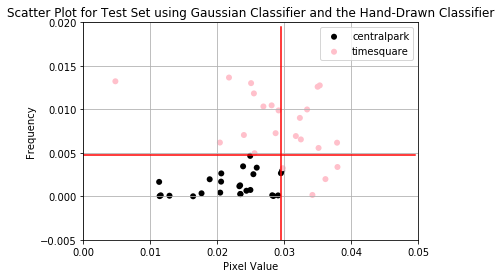

In [18]:
fig, ax = plt.subplots()

ax.scatter(c_test_feature[:, 0], c_test_feature[:, 1], c='black', label='centralpark', edgecolors='none')
ax.scatter(t_test_feature[:, 0], t_test_feature[:, 1], c='pink', label='timesquare', edgecolors='none')

x_plots = np.arange(0, 0.05, 0.0005)
y_plots = np.array([0.0047]*len(x_plots)) 
ax.plot(x_plots, y_plots, color='red')

y_plots = np.arange(-0.005, 0.02, 0.0005)
x_plots = np.array([0.0295]*len(y_plots)) 
ax.plot(x_plots, y_plots, color='red')

ax.set_xlabel('Pixel Value')     
ax.set_ylabel('Frequency')     

ax.set_xlim(0, 0.05)
ax.set_ylim(-0.005, 0.02)

ax.set_title('Scatter Plot for Test Set using Gaussian Classifier and the Hand-Drawn Classifier')
ax.legend()
ax.grid(True)

plt.show()

Finally, the error rate of this Gaussian classifier is computed as below.

In [19]:
classification_labels = []

for label in classification_result:
  if label:
    classification_labels.append('centralpark')
  else:
    classification_labels.append('timesquare')

false_prediction = 0
for i in range(0, len(classification_result)):
  if classification_labels[i] != test_labels[i]:
    false_prediction = false_prediction + 1

error_rate = false_prediction/len(test_labels)

print('Test error rate: {}'.format(error_rate))
print('Test accuracy: {}'.format(1 - error_rate))

Test error rate: 0.22916666666666666
Test accuracy: 0.7708333333333334


# Problem 2

Research an application for computer vision, describe the underlying problem and the methods used to solve it. If the application was presented in popular media (e.g., NY Times), track down the scientific methods used in the academic literature. Include references. It is ok if this is related to what you are thinking about for your final project! This write-up should be a two to three pages including images and diagrams as needed. 

# Topic: Object Detection Algorithms

I pick Object Detection as the topic because it has massive applications for so many use cases, e.g. pose estimation and self-driving cars. My explanations will cover the following:

1. The problem description
2. The underlying problem
3. The popular algorithms for object detection and the advantage/disadvantage of using them 

I will cover four algorithms: R-CNN, Fast R-CNN, Faster R-CNN and YOLO.

Below are the references that I will use for the explanations:
1. [Rich feature hierarchies for accurate object detection and semantic segmentation](https://arxiv.org/pdf/1311.2524.pdf)
2. [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf)
3. [Faster R-CNN: Towards Real-Time Object
Detection with Region Proposal Networks](https://arxiv.org/pdf/1506.01497.pdf)
4. [You Only Look Once:
Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640v5.pdf)
5. http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf

## 1. Problem Description

Object detection is different from image classification in a sense that instead of only determining what class the image belongs to, we also need to predict the bounding box around the object of interest within an image. There could be more than one bounding box for multiple objects. They could be the same/similar objects (e.g. flock of birds, people in streets) or different objects (e.g. vehicles in streets which could be cars, motorbikes, buses, etc.). Note that in most problems, you don't know how many objects the model should detect inside an image, which makes this problem very challenging in nature.

<img src="images/fig1.png">

Figure 1: Object Detection Examples [3]

## 2. The Underlying Problem



We might want to ask why we couldn't approach this problem the same as we approach image classification, for example using CNN followed by dense layers. The answer would be simply because as I've mentioned before, we don't have the information of how many objects are to be detected before we actually start scanning the image itself. Thus, this makes the size of our output layer to vary. 

We could still, however, try to make a workaround by dividing the images into several distinct regions and for each region, we apply our CNN to classify whether or not there is object present. Let's call this the Naive approach for reference in the later section of my explanation. But, then again, there is a problem. Our objects of interest, with a very high odds, could have different spatial locations within the image (they might even have overlap bounding boxes) and they could have different aspect ratios as well, which affects the size of your input layer. The consequence would be you need to be very granular, i.e. defining very small regions and ends up having big number of regions, which of course, is computationally expensive. 

## 3. The Algorithms

The algorithms below are the most popular ones and they handle the underlying problems that I've pointed out above.

### 3.1 R-CNN

R-CNN is proposed by Ross Girshick, et al. in [1], from UC Berkeley. The idea is fairly simple actually. Instead of defining a big number of regions, they define only 2000 regions. But, the regions are not picked at random. They propose a selective search method to get them. The algorithm in the nutshell is as below:

1. Generate initial subsegmentation where we generate many candidate regions (far greater than 2000). This is the same as the Naive approach.
2. We apply a greedy algorithm to combine similar regions into a larger one, recursively (so combined regions might be combined again).
3. The resulting regions after applying the greedy algorithm are our final candidate regions, which are 2000 in total

The scheme is as in the picture below.

<img src="images/fig2.png">

The candidate regions are then fed into a CNN, as the feature extractor, resulting in a feature vector of size 4096. It is then fed to dense layers and finally we have SVM (one vs rest) at the end of our pipeline to classify whether or not the object is present within the candidate region. The classification scheme is as in the picture below.

<img src="images/fig3.png">

In addition to predict the presence of the object, this algorithm also predicts four values, which are the offset values. This is to accommodate if the object doesn't fully lie within a certain candidate region, e.g. if it is a car, it's tire might be outside the candidate region. This way, the bounding box might be more accurate. 

Still, there are problems associated with this R-CNN, which are:
1. It doesn't really speed up the computation as you still have to classify 2000 region proposals per image
2. Based on [1], it takes 47 seconds in average to classify an image, something that is not suitable for production scale
3. The selective search algorithm is greedy, meaning that it is fixed and no learning is involved. This, of course, might yield unrelevant regions.

### 3.2 Fast R-CNN

This is the continuation of R-CNN, basically, trying to fix the computational drawback of R-CNN. The author is still the same [2], but was under different umbrella, which was for Microsoft Research. Here are the differences:

1. This time around, you don't feed the region proposals to the CNN. Instead, you feed the image directly to the CNN, resulting into a convolutional feature map.
2. Then, we do the usuals, which is applying the selective search algorithm. We identify the candidate regions and warp them into squares just like a normal R-CNN. RoI pooling layer is then used to fix the size before it is fed to the dense layers. 
3. Finally, insted of using one vs rest SVM, the author uses softmax, as it is proven to yield an improvement for the mAP (the metric used), even though not as significant.

Below is the updated scheme:

<img src="images/fig4.png">

Fast R-CNN is faster than R-CNN (of course, as the name claims to be) because you don't feed the 2000 regions to the CNN every time. The convolution operation is done only once per image, i.e. when creating the convolutional feature map. It's a simple trick but it does wonders in my opinion. Below are the performance comparison, speed wise, for R-CNN and Fast R-CNN.

<img src="images/fig5.png">

The training time speed up is around 10-20 times quicker meanwhile for testing time, it could be as extreme as 200 times quicker, that's the case when using SVD for large images. However, Fast R-CNN still doesn't solve the problem that the greedy algorithm is fixed and no learning is involved. Again, this might result in unrelevant regions produced.

### 3.3 Faster R-CNN

The naming is indeed funny, but it comes from different author this time, which is Shaoqing Ren, et al. [3]. This approach is introduced exactly to solve the problem in R-CNN and Fast R-CNN that I've pointed out before. Now, instead of using a greedy algorithm to select regions, we use the network to learn where are the relevant regions. Here are the differences:

1. The initial steps are the same, which is to create a convolutional feature map from the image
2. Now, instead of applying selective search algorithm, we create yet another neural network to predict the region proposalsm, straightforwardly called the Region Proposal Network
3. The rest of the steps are basically the same, which is to use RoI pooling layer to fix the size before we feed it to the dense layer
4. The output is also the same as R-CNN and Fast R-CNN, which is the presence of the object and the offset values if the object is present

Below is the updated scheme:

<img src="images/fig6.png">

As I've explained, the difference is solely on the way that the region is defined, which is now determined by the RPN (Region Proposal Network). The high level detail of the network is depicted in the picture below.

<img src="images/fig7.png">

### 3.4 YOLO (You Only Look Once)

The naming is now even funnier. As the name suggests, we will look into the image only once, but it will cover all the areas/parts of the image. Previously, in R-CNN variants, we only consider parts of the image which are highly likely to contain the object of interest. YOLO [4] uses a CNN to predict the bounding boxes, outputting probabilities. Take a look at the scheme below.

<img src="images/fig8.png">

The steps in YOLO are as the following:

1. We split the input image into $SxS$ grid
2. For each grid, we then split again into $m$ bounding boxes
3. For each bounding box, the CNN based network will output a class probability and the offset values, pretty much the same as R-CNN
4. Finally, to identify an object, we select the bounding boxes which have the class probability above the threshold value for that class. Notice that this way, we might have bounding boxes that contains multiple objects. Looking at the scheme above, we can see that there are bounding boxes which contain both the dog and the bike.

YOLO, however is not perfect. YOLO imposes strong spatial constraints on bounding box predictions since each grid cell only predicts two boxes
and can only have one class. This spatial constraint limits the number of nearby objects that YOLO could predict. YOLO struggles with small objects that appear in groups, such as flocks of birds.

Since YOLO learns to predict bounding boxes from labeled data, it struggles to generalize to objects in new or unusual aspect ratios or configurations. YOLO also uses relatively coarse features for predicting bounding boxes since our architecture has multiple downsampling layers from the input image.

While YOLO is trained on a loss function that approximates detection performance, its loss function treats errors the same in small bounding boxes versus large bounding boxes. A small error in a large box is generally benign but a small error in a small box has a much greater effect. To sum up, YOLO's main source of error is incorrect localizations.

Despite the limitation, YOLO really brings into realization that we could have a real time object detector that is fairly stable in terms of prediction performance. Below is the FPS (frame per second) comparison of YOLO and other algorithms. FPS basically means how many frame/image can an algorithm process within a second.

<img src="images/fig9.png">

We could see that there is a decrease in accuracy performance, measured by mAP, $70$ for Faster R-CNN with VGG-16, and only $63.4$ for YOLO. But, the difference in speed performance is huge. YOLO could process up to 45 FPS, while Faster R-CNN with VGG-16 could only afford at most 7.